# 文本匹配之BM25算法

## M25算法介绍

BM25算法在Elasticsearch中用于衡量Query和库中Doc之间的相关性，是文本匹配常用的算法之一。

1、主要思想

1）对Query进行语素解析，生成语素 

2）对于每个搜索文档d，计算每个语素与d的相关性得分

3）将相对于d的相关性得分进行加权求和，从而得到Query与d的相关性得分。

2、算法解析

1）公式介绍

BM25算法公式如下

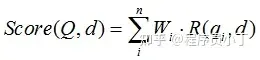

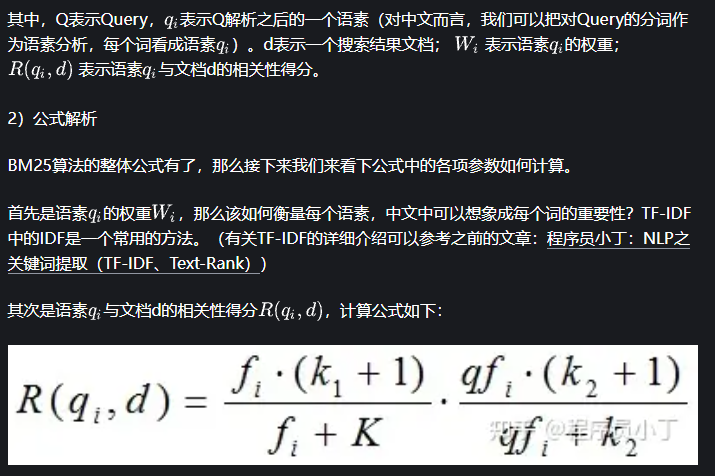

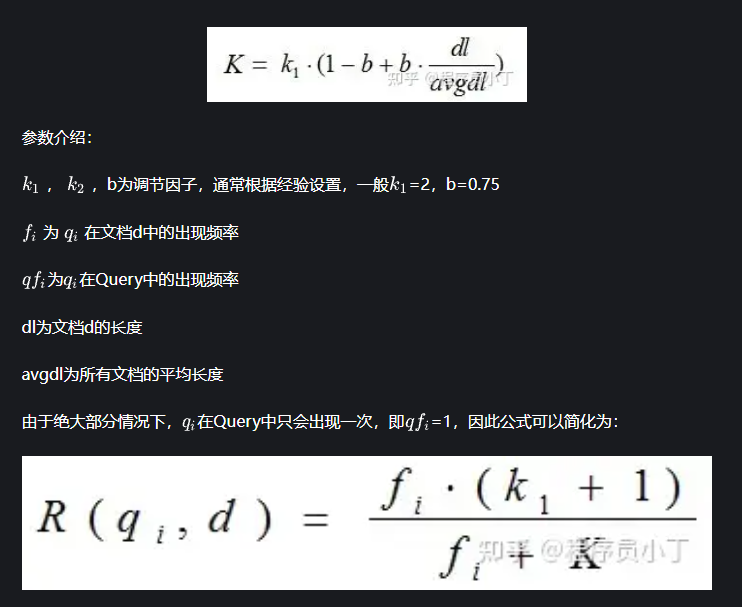

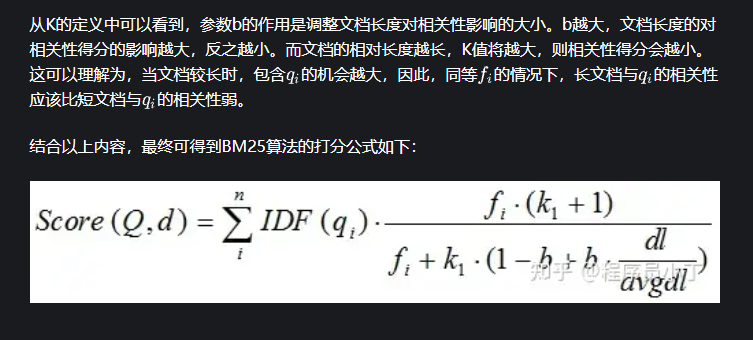

In [2]:
import jieba
from gensim.summarization import bm25

In [4]:
class BM25Model:
    def __init__(self, data_list):
        self.data_list = data_list
         # corpus : list of list of str
        self.corpus = self.load_corpus()
        
    def load_corpus(self):
        """构造语料库
        """
        corpus = [jieba.lcut(data) for data in self.data_list]
        return corpus
    
    def bm25_similarity(self, query, num_best=1):
        query = jieba.lcut(query)
        print(query)
        bm = bm25.BM25(self.corpus)
        print(bm)
        scores = bm.get_scores(query)
        print(scores)
        id_score = [(i, score) for i, score in enumerate(scores)]
        id_score.sort(key=lambda x: x[1], reverse=True)
        return id_score[: num_best]
    

if __name__ == "__main__":
    data_list = ['我喜欢nlp', '我不喜欢nlp', '我需要学习nlp']
    
    BM25 = BM25Model(data_list)
    query = "我喜欢学习nlp"
    print(BM25.bm25_similarity(query, 1))

['我', '喜欢', '学习', 'nlp']
[-0.39074083609362753, -0.3446709558555142, 0.2609688703111038]
[(2, 0.2609688703111038)]


# 文本匹配之方案解析

## 方案介绍

主要有交互式和特征式两者实现方案

### 交互式方案（单塔式）

具体实现：把两个文本拼接在一起当成单文本，通过编码器获得一个句向量表示，然后以该句向量作为输入接一个分类器进行0,1的二分类，1表示相似，0表示不相似。

### 特征式方案（双塔式）

指两个文本分别通过编码器编码为向量后，然后再通过这两个向量来衡量文本的相似度

文本相似度的衡量：

1）直接计算两个向量的相似度，把这个值作为两个文本相似或者是说匹配程度的依据

2）对这两个向量直接拼接再接一个分类器进行二分类，但是这种效果往往不好，因为两个文本没有产生过多的特征交互。所以出现了另一种做法，对两个向量再进一步进行各种特征交互，然后再分类，以ESIM（在随后的文章中再具体介绍）为典型代表。

那么是否用参数共享该如何选择？可以参考苏剑林大佬在这篇文章评论中的回复（CoSENT（二）：特征式匹配与交互式匹配有多大差距？ - 科学空间|Scientific Spaces）

要算相似度的两个对象是同一空间的东西（比如都是query），并且你希望sim(x,y)=sim(y,x)，那么参数共享是一种很自然的选择。

如果你要算相似度的东西不是同一空间的，但没有明显交集，比如query和answer，虽然属于不同类型的文本，但可以认为query和answer基本没交集，这时候用参数共享通常也不错。

如果不是上述两种情形，那么用参数共享通常是不合理的。但是参数完全不共享效果通常也不好。比较合理的做法是共享前面的大部分，剩下后面小部分不共享。

从训练数据角度：

根据是否必须需要有标签的数据又可分为有监督式和无监督式。不需要带标签数据的无监督式大多是融入对比学习例如simcse.

3、交互式和特征式的优劣对比
交互式

优点：由于使得两个文本能够进行充分的比较，所以它准确性通常较好

缺点：检索场景的效率较差，因为线上使用每次都需要把query和每个候选的文本拼接整体作为输入通过模型进行相似度打分

特征式

优点：可以提前获取候选文本的向量表示，存入到向量化数据库中，线上只需要用模型对query编码一次，然后结合向量化数据库进行和候选文本的文本匹配，有着较高的效率。

缺点：由于句子间的交互程度较浅，所以通常效果不如交互式。

# Sentence-BERT（SBERT）

https://www.sbert.net/docs/training/overview.html

Sentence-BERT也可以说是对InferSent有效性的进一步验证，完全依赖于InferSent的思想，编码器换成了效果更好的Bert系列。它属于特征式实现方案，编码器的参数共享。

对于通过Bert获取句向量的方法，作者对比了三种形式：CLS向量，平均池化和最大值池化，其中平均池化的效果最好。

同时针对不同类型的任务，作者使用了不同的目标函数

1）分类任务

模型设计如下
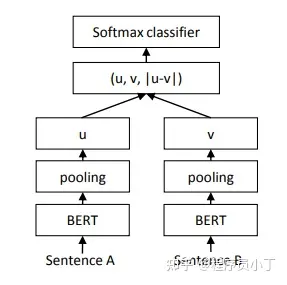
loss使用的是分类常用的cross-entropy loss

2）回归任务
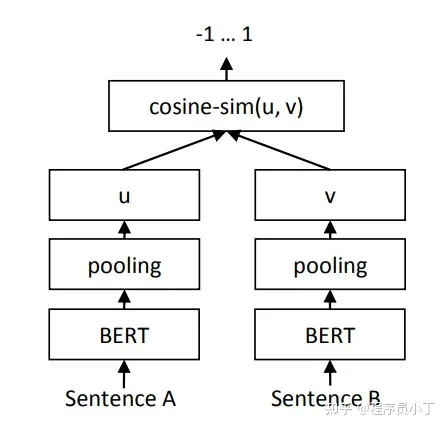
获取u,v之后计算余弦值，loss使用的是回归任务中常用的均方差损失函数

3）Triplet Objective Function

使用的Loss也是目前比较常用的：
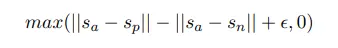

缺点：相比于交互式效果确实差一些，但最主要的优势是快。使用方法是把候选文本通过训练好的模型编码成向量后存到向量化数据库，线上只需要把待查询文本通过模型进行编码，然后计算余弦相似度获取相似度得分

In [3]:
# 导入包并选择预训练模型
from sentence_transformers import SentenceTransformer, models

model_path = r"D:\code\personal\models\bert-base-chinese"
# model = SBert(model_path)

# 加载模型
word_embedding_model = models.Transformer(model_path, max_seq_length=512)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())

model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

# 对句子编码
sentenct1 = ['肠道不好']
sentenct2 = ['你好，肠道问题的话，推荐便通胶囊']

embedding1 = model.encode(sentenct1)
embedding2 = model.encode(sentenct2)
# encode()传入的必须是列表

# 计算余弦相似度
from sentence_transformers.util import cos_sim
coine_scores = cos_sim(embedding1, embedding2)

print(coine_scores)

Some weights of the model checkpoint at D:\code\personal\models\bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tensor([[0.7110]])


In [6]:
# 在自己的数据集上微调预训练模型
from sentence_transformers import SentenceTransformer, SentencesDataset, InputExample, evaluation, losses
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, util
from sentence_transformers import evaluation

# 训练集
train_examples = [
   InputExample(texts=['My first sentence', 'My second sentence'], label=0.8),
   InputExample(texts=['Another pair', 'Unrelated sentence'], label=0.3)
]


# 微调
# Define the model. Either from scratch of by loading a pre-trained model
model_path = r"D:\code\personal\models\bert-base-chinese"
word_embedding_model = models.Transformer(model_path, max_seq_length=512)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

# Define your train dataset, the dataloader and the train loss
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
train_loss = losses.CosineSimilarityLoss(model)

# Tune the model
model.fit(train_objectives=[(train_dataloader, train_loss)], 
          epochs=1, warmup_steps=100, 
          output_path='./Ko2CnModel')

Some weights of the model checkpoint at D:\code\personal\models\bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:

# 加载训练好的模型
# model = SentenceTransformer('./Ko2CnModel')

word_embedding_model = models.Transformer('./Ko2CnModel', max_seq_length=512)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

# Sentences are encoded by calling model.encode()
emb1 = model.encode("터너를 이긴 푸들.")
emb2 = model.encode("战胜特纳的泰迪。")

cos_sim = util.pytorch_cos_sim(emb1, emb2)
cos_sim

TypeError: __init__() got an unexpected keyword argument 'token'